# Decision Trees

Image source: https://cloud2data.com/what-is-decision-tree-in-machine-learning/


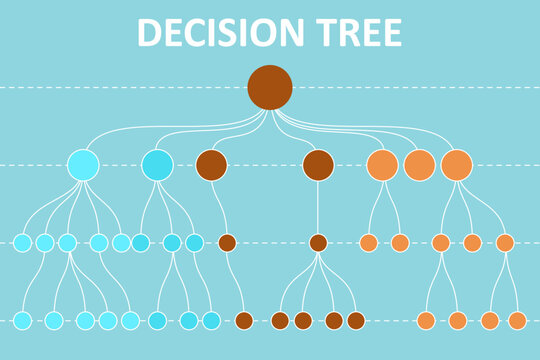

In [2]:
from IPython import display
print(f"Image source: https://cloud2data.com/what-is-decision-tree-in-machine-learning/")
display.Image("images/dec_tree.jpeg")

**Decision Trees** are a very useful family of algorithms and, though they are rearely used in academia, versions of them (like XGBoost and LightGBM) are extensively used in competitions and industry.

These algorithms have several benefits: 
- are easy to understand 
- decisions can be tracked (providing explainability)
- can be used for both regression and classification

However, there are some downsides as well:
- it's easy to end up with overfitting models
- usually won't extrapolate well (they work best within the range of training data)
- if training data ins imbalanced, the model might end up biased and perform poorly on the majority class.
- work better for categorical features than for continuous features
- it's easy to arrive at suboptimal models (unless we use a large number of trees, which is the basis of Random Trees and XGBoost algorithms)


The concept behind decision trees is quite simple at its core: split the data into left-right branches according to the value of some feature (variable) and continue splitting until a limit criteria is reached. 

To use an example by Andrew Ng, say we have data on animals and we want to classify cats, we have:
- ear shape: pointy | floppy
- face shape: round | not round
- whiskers: persent | not present

Image source: Prof. Andrew Ng's ML Specialisation


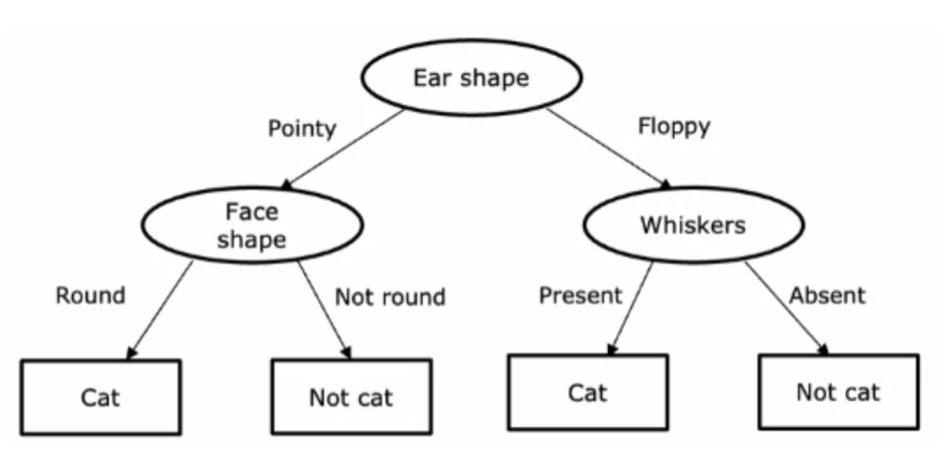

In [3]:
from IPython import display
print(f"Image source: Prof. Andrew Ng's ML Specialisation")
display.Image("images/tree_cats.jpeg")

The picture above shows how data can be devided according to some criteria. The final boxes (known as **'terminal nodes'**) define the classification, in this case "Cat/Not Cat". The training_data is used to structure (build) the tree until all terminal nodes are defined, then to classify new data we 'run it through the tree' to figure out at which terminal node it ends up. Continuing with the previous example, say we have an animal "*with floppy ears and whiskers*", we would go through the tree and end up at the "Cat" terminal node on the right of the tree, meaning that the model would classify this new animal as a 'cat'. As we see, it is quite easy to explain how the tree works and makes classification predicitions. 

For **classification cases**, we assign to the new data the prevalent class on the terminal node at which the new case ends up. For **regression cases**, we usually assign as prediction for the new data the mean of the output value of the samples at the terminal node. It's important to note that other methods are also used, like a weighted mean, a linear regression of values in the terminal node, the median of the output values at the node, etc. It might be easy to see why, particularly for regression cases, tree-based models won't extrapolate adequately for data outside the training range.

## The theory in detail

 Here, we'll see the classification case, which  can be understood as a series of binary splits of data forming "branches" (each split representing a "node" usually known as **decision nodes**). These binary splits are performed in response to a "question" or **"tests"** with which we assess the data. The splits can be performed over both numerical and cathegorical data (which is an important 'plus' for this algorithm). The end nodes of a branch are known as **"leaf nodes"** and define a "prediction" for the value of a sample. To classify new values we analysed on which 'leaf node' it ends at and assign it a classification according to the classificiation most prevalent on that node.

A common way to desing a tree is to analyse the level of 'information' that we can get with different splits for the analised node. Notice that the method analyses one node at a time, hence, it is possible that a tree designed by finding the optimal split for each node is not the optimal tree overall. However, it must also be noted that analysing all the possible splits for the whole tree is computationally very expensive.

Now we need a criteria to split the tree. There are 2 common (and differentiable, thus easier for maximisation) ways to do this:

$$ \textrm {Gini index}= \sum_{k=1}^{K}p_{mk}(1 - p_{mk})$$ 

$$\textrm {Cross-Entropy (or just entropy)}= - \sum_{k=1}^{K}p_{mk}log_2(p_{mk})$$

where k = 1,..., K are the classification values, '*m*' is the node analysed and $p_{mk}$ is the proportion of data classified as *k* for node *m* (which can also be interpreted as the probability of class *k* on node *m*).

We'll continue using Entropy for this exercise. Notice that Entropy will be small when $p_{mk}$ is close to both 1 and 0. Interpreting *p* as a probability again, this would mean that **Entropy is smaller when the uncertainty is smaller** (*p*=1 and *p*=0 present zero uncertainty). Notice that this means that nodes lower on the tree (or children nodes) will most likely have lower entropy (since they will have a less diverse set of classes than the nodes before them -known as parent nodes) and that the starting node (or **root node**) is usually the one with the highest entropy.

In general terms, the Tree Creation algorithm follows these steps:

1) Calculate the information gain for **each possible split** of features and feature values (ie: the algorithm analyses all possibilities).\
2) Create a node splitting the data set using the feature and values for that feature that yield the **maximum information gain** for that split (information gain can be defined as the Entropy or the Gini index).\
3) Continue creating decision nodes/splits until a stopping criteria is reached. Common creteria are:\
    Maximum Depth\
    Minimum number of samples\
    Minimum impurity decrease
    
This is known as a **greedy approach** since it tries to maximise the entropy on every step (instead of trying to look at the whole tree for the best overall splits).

Growing a Decision Tree implies defining the "if/else" questions and their thresholds in order to get an answer as quickly as possible for new data.

Common problems with Decision Trees is their high variance when we use (even slightly) different data, which can trigger a different split on one or several nodes, as well as their proclivity to 'overfit' the model to a particular training data set which leaves us with a model that performs poorly on new data.

Common strategies to prevent overfitting are:
1) **Pre-pruning**: stopping the creation of more branches early by **limiting the depth** of the tree (number of levels)or requiring a minimum numer of samples in a node to continue splitting (notice that this is the method used in scikit-learn)\
2) **Post-pruning**: growing the tree completely and then prune it.

Finally, a key concept in Decision Trees is the **Information Gain** or reduction of entropy. As we've said, the root node has the highest entropy in a Tree and, given the greedy algorithm often used to grow it, subsequent nodes will dedice the entropy. The change in entropy between a (partent) node and the ones splitting from it (children) is known as information gain:

$$\textrm {Information Gain = Parent-Entropy - weighted-avg * Children-entropy}$$

Where the weighted average is defined by the number of samples at every children node.

### Coding a Decision Tree

We'll use 2 classes: Node and DecisionTreeClassifier.

To avoid overfitting, we'll use a min_number of samples to split (2) and a maximum depth (50). We will analyse the effect of increasing the max_depth later.

Notice that part of this code was inspired "Data Science from Scratch" by j. Grus and "AI and Machine Learning for Coders" by L. Moroney. It also uses examples from @AssemblyAI

**Class Node**: defines a node with attributes: index, threshold, left_branch and right_branch

**Class DecisionTreeClass** with methods:\

**_entropy**: returns the entropy of a node calculated as $\sum -{p}*{log(p)}$\

**_split**: separates a received sample X according to a received threshold, splitting the sample in "left" and "right" branches\

**_inf_gain**: calculates and returns information gain determined as parent_node_entropy - children_node_entropy (this is calculated for all possible splits\

**_best_split**: goes through all possible splits on a given node and uses **_inf_gain** for all of them to determine the one that **returns the feature** (index) **and the threshold** that define the best split (max inf_gain) for that node/

**_grow_tree**: this is the heart of the code. This method uses itself recursively and _best_split to generate the branches of the tree until it reaches a node . It returns a Node class, defined by its index (feature), threshold (that separates the branches that grow from that node) and the left-right branches (defined by Nodes as the method calls itself recursively)/

**_gothrough_tree**: starting from a given node, uses it's index feature and threshold to go through the tree until it finds an end node and **returns that end node's value**
    
**predict**: uses _gothrough_tree and a new sample X to find and end node and its value as a prediction
    
**fit**: uses _grow_tree from the root to create a tree using training samples X and values/classes y

In [4]:
import numpy as np
from collections import Counter

class Node():
    def __init__(self, index = None, threshold = None, left_branch = None, right_branch = None, info_gain = None, *, value = None):
        
        #decision nodes 
        self.feature_index = index
        self.threshold = threshold
        self.left = left_branch
        self.right = right_branch
        self.info_gain = info_gain
        self.value = value #Notice that value is only defined for leaf/terminal nodes 
        
    #for leaf or terminal nodes we need to define a value to define to ease the class definition
    def is_leaf_node(self):
        return self.value is not None

class DecisionTreeClass():
    def __init__(self, min_samples_split = 2, max_depth = 50, n_features = None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        #get characteristics of the [remaining] training data set (consider the min between the defined features and the given features)
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    #this is the key method. It recursively create tree (with initial depth = 0)
    def _grow_tree(self, X, y, depth = 0):
        n_samples = X.shape[0]
        n_rem_labels = len(np.unique(y)) #records the different labels for the remaining samples in the training set
        
        #check stopping criteria: size of tree, only 1 label (entropy = 0)
        if (depth >= self.max_depth or n_rem_labels == 1 or n_samples <= self.min_samples_split):
            counter = Counter(y)
            leaf_value = counter.most_common(1)[0][0] #this is the label of the most common element in this terminal node
            return Node(value = leaf_value)
        
        #find the best split for the node. We shuffle the features. 
        #Notice that we can also select just a portion of the feature, this is useful for the random trees algorithm
        feat_indexes = np.random.choice(range(self.n_features), self.n_features, replace = False) 
        best_feat, best_thrsh  = self._best_split(X, y, feat_indexes)
        
        #create children nodes recursively slicing the sample
        left_indexes, right_indexes = self._split(X[:, best_feat], best_thrsh)
        left = self._grow_tree(X[left_indexes], y[left_indexes], depth + 1)
        right = self._grow_tree(X[right_indexes], y[right_indexes], depth + 1)
        return Node(best_feat, best_thrsh, left, right)
        
        
    #this function evaluates all possible splits and defines the one 
    #that maximises the information gain
    def _best_split(self, X, y, feat_indexes):
        best_gain = -10
        split_index, split_thrshld = None, None
        
        #we define all possible splits
        for f_indx in feat_indexes:
            X_col = X[:, f_indx] #selects all rows for the f_indx column
            thrshld = np.unique(X_col) #takes all the unique possible splits in the col
            
            #calculates inf gain for all combinations
            for thr in thrshld:
                inf_gain = self._inf_gain(y, X_col,thr)
                
                #update the register for the best gain split
                if inf_gain > best_gain:
                    best_gain = inf_gain 
                    split_index = f_indx
                    split_thrshld = thr
        
        return split_index, split_thrshld

    ##calculates and returns information gain for a given threshold to split on a node    
    def _inf_gain(self, y, X_col, thr):
        #parent's entropy
        parent_entropy = self._entropy(y)
        
        #define children's branches by indixes
        left_branch, right_branch = self._split(X_col, thr)
        
        #if there's no more splitting to do, inf. gain is null
        if len(left_branch) == 0 or len(right_branch) == 0:
            return 0
        
        #define children's entropy
        n_left, n_right = len(left_branch), len(right_branch)
        entropy_left, entropy_right = self._entropy(y[left_branch]), self._entropy(y[right_branch])
        children_entropy = (n_left/len(y))*entropy_left + (n_right/len(y))*entropy_right
        
        #calculate information gain
        inf_gain = parent_entropy - children_entropy
        return inf_gain
        
    #returns arrays with left-right branches according to a threshold value and a feature (X_col)
    def _split(self, X_col, split_thr):
        left_child = np.argwhere(X_col <= split_thr).flatten() #we use flatten() to have just one array
        right_child = np.argwhere(X_col > split_thr).flatten() #we use flatten() to have just one array
        return left_child, right_child
    
    #calculate entropy for a given sample set of labels
    def _entropy(self, y):
        labels, labels_count = np.unique(y, return_counts = True)
        prop_label = labels_count / len(y)
        return -np.sum([p*np.log(p) for p in prop_label if p > 0])
    
    #return an array of the predictions for an array of values    
    def predict(self, X):
        return np.array([self._gothrough_tree(x, self.root) for x in X])
        

    #recursively determine the end_node for a given value and return its most prominent label(prediction)
    def _gothrough_tree(self, x, node):

        #for terminal node, return its value
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._gothrough_tree(x, node.left)
        return self._gothrough_tree(x, node.right)

To test the code I'll use the openly available 'iris.csv' database and we will split the data into training and test sets using sklearn



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("data/Iris.csv", skiprows = 1, header = None, names = col_names)
data.head(10)

print(f"Shape of loaded data: {data.shape}")

# prepare data to be used with sklearn
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)


Shape of loaded data: (150, 5)


Now, let's fit the model and make predictions for the test set. We use 500 as the max depth and a minimum of 20 samples to stop splitting and define an end node.

In [6]:
import time

# fitting the model and assessing the computing time
time_ini_self_coding = time.time()
dt = DecisionTreeClass(min_samples_split = 20, max_depth = 500, n_features = None)
dt.fit(X_train, y_train)
time_end_self_coding = time.time()

time_self_code = time_end_self_coding - time_ini_self_coding

predictions_self_code = dt.predict(X_test)

Now, let's look at the **code with Sklearn**:

In [13]:
from sklearn import tree
import time

# fitting the model and assessing the computing time
time_ini_sklearn = time.time()
clf = tree.DecisionTreeClassifier(random_state = 0)
clf.fit(X_train, y_train)
time_end_sklearn = time.time()

time_sklearn = time_end_sklearn - time_ini_sklearn

predictions_sklearn = clf.predict(X_test)

In [14]:
# function to evaluate accuracy
def accuracy(y_test, y_prediction):
    return np.sum(y_test == y_prediction) / len(y_test)

Now, let's compare results:

In [15]:
acc_self_code = accuracy(y_test, predictions_self_code)
acc_sklearn = accuracy(y_test, predictions_sklearn)

print(f"Accuracy for self code: {acc_self_code:.4f}\nTime to fit: {time_self_code:.6f}")
print("\n")
print(f"Accuracy for sklearn: {acc_sklearn:.4f}\nTime to fit: {time_sklearn:.6f}")

# increased/decreased efficiency with sklearn:
print(f"Sklearn is {(time_self_code/time_sklearn):.0f} times faster than the python code")

Accuracy for self code: 0.8333
Time to fit: 0.161695


Accuracy for sklearn: 0.9000
Time to fit: 0.002943
Sklearn is 55 times faster than the python code


Another useful function of sklearn is the ease with which we can plot the resulting tree:

[Text(0.3333333333333333, 0.9285714285714286, 'x[3] <= 0.7\ngini = 0.667\nsamples = 120\nvalue = [41, 39, 40]'),
 Text(0.2222222222222222, 0.7857142857142857, 'gini = 0.0\nsamples = 41\nvalue = [41, 0, 0]'),
 Text(0.4444444444444444, 0.7857142857142857, 'x[3] <= 1.55\ngini = 0.5\nsamples = 79\nvalue = [0, 39, 40]'),
 Text(0.2222222222222222, 0.6428571428571429, 'x[2] <= 5.25\ngini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.6666666666666666, 0.6428571428571429, 'x[2] <= 5.05\ngini = 0.093\nsamples = 41\nvalue = [0, 2, 39]'),
 Text(0.5555555555555556, 0.5, 'x[1] <= 2.9\ngini = 0.375\nsamples = 8\nvalue = [0, 2, 6]'),
 Text(0.4444444444444444, 0.35714285714285715, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 5]'),
 Text(0.6666666666666666, 0.35714285714285715, 'x[3] <= 1.75\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text

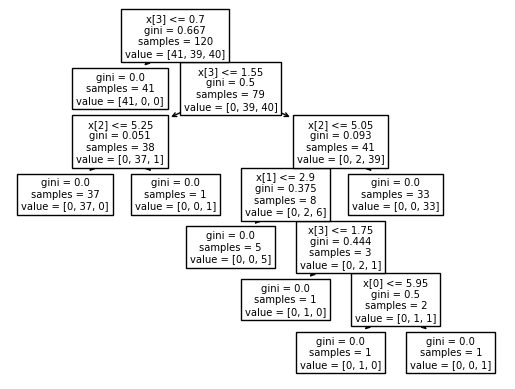

In [18]:
tree.plot_tree(clf)

Notice that the Sklearn algorithm achieved a 6.7% better accuracy, but fitting the model much faster than our Python coded version.